# 1.0. Installing Libraries

In [7]:
!pip install tensorflow




  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/375.9 MB 1.7 MB/s eta 0:03:44
   ---------------------------------------- 1.0/375.9 MB 2.0 MB/s eta 0:03:07
   ---------------------------------------- 1.3/375.9 MB 1.9 MB/s eta 0:03:16
   ---------------------------------------- 1.8/375.9 MB 1.9 MB/s eta 0:03:21
   ---------------------------------------- 2.1/375.9 MB 2.0 MB/s eta 0:03:08
   ---------------------------------------- 2.6/375.9 MB 1.8 MB/s eta 0:03:28
   ---------------------------------------- 3.1/375.9 MB 1.9 MB/s eta 0:03:12
   ---------------------------------------- 3.4/375.9 MB 1.9 MB/s eta 0:03:13
   -------------------------------

# 2.0. Importing Libraries

In [2]:
import pandas  as pd
import numpy   as np
import scipy   as sp

from sklearn.cluster          import AgglomerativeClustering
from sklearn.metrics.pairwise import nan_euclidean_distances

In [5]:
import matplotlib        as mpl
import matplotlib.pyplot as plt
import seaborn           as sns
import geopandas         as gpd

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from scipy.ndimage   import gaussian_filter
from scipy.spatial   import voronoi_plot_2d

In [8]:
import tensorflow as tf

from tensorflow       import keras
from tensorflow.keras import layers
from sklearn.metrics  import mean_absolute_error
from sklearn.metrics  import mean_squared_error

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

# 3.0. Data Paths

In [10]:
path = "/content/drive/MyDrive/Ovitraps/CBIC/data/"

path_eggs_data    = path + "eggs_data/"
path_map_data     = path + "map_data/"
path_models_data  = path + "models_data/"

# 4.0. Plot Patterns

In [11]:
colors = {
  "color_north": "#B4C4DF",
  "color_east" : "#FFF7FB",
  "color_west" : "#258BAE",
  "color_south": "#014636",
}

cmap = "PuBuGn"

In [12]:
mpl.rcParams['figure.figsize'] = (18, 8)

In [13]:
sns.set_theme()

# 5.0. Auxiliar Functions

In [14]:
def month_rename(month):
  month_dict = {
    "Janeiro": "Jan",
    "Fevereiro": "Feb",
    "Março": "Mar",
    "Abril": "Apr",
    "Maio": "May",
    "Junho": "June",
    "Julho": "July",
    "Agosto": "Aug",
    "Setembro": "Sep",
    "Outubro": "Oct",
    "Novembro": "Nov",
    "Dezembro": "Dec"
  }

  return month_dict.get(month, "")

def district_rename(district):
  district_dict = {
    "Norte": "North",
    "Norte 1": "North",
    "Norte 2": "North",
    "Sul": "South",
    "Leste": "East",
    "Oeste": "West",
  }

  return district_dict.get(district, "")

In [15]:
def Get_ReorderTraps(eDist, NNeigh):
  # Here we order traps by proximity, return the NNeigh traps for each one
  cnt_Trap = 0
  Current_Trap = 0
  N = len(eDist)
  Ordered_Traps =  np.array(0, dtype=np.uint16)
  Neigh_Traps =  np.zeros((N,NNeigh), dtype=np.uint16)
  Sort_Dist =  np.zeros((N,NNeigh), dtype=np.float16)

  while cnt_Trap<(N-1):
    Dist = eDist[Current_Trap,:]
    #Dist = np.delete(Dist, Ordered_Traps)
    sortIndx = np.argsort(Dist)
    I = ~np.isin(sortIndx, Ordered_Traps)

    Neigh_Traps[cnt_Trap,:] = sortIndx[0:NNeigh]
    Sort_Dist[cnt_Trap,:] = Dist[sortIndx][0:NNeigh]
    cnt_Trap = cnt_Trap + 1

    Current_Trap = sortIndx[I][0]
    Ordered_Traps = np.append(Ordered_Traps, Current_Trap)

  Dist = eDist[Current_Trap,:]
  sortIndx = np.argsort(Dist)
  Neigh_Traps[cnt_Trap,:] = sortIndx[0:NNeigh]
  Sort_Dist[cnt_Trap,:] = Dist[sortIndx][0:NNeigh]
  return Ordered_Traps, Neigh_Traps, Sort_Dist

In [16]:
def AggregateTraps(Ordered_Traps, Loc, NNeigh):
  # Aggregate locations, return centroids and Traps used to aggregate
  NTraps = len(Loc)
  NCent = np.uint8(NTraps/NNeigh)
  Cent = np.zeros((NCent,2),dtype=np.float32)
  Traps = np.zeros((NCent,NNeigh),dtype=np.uint16)

  #Current_Cent = Loc[Current_Trap,].reshape(1,2)
  for iCent in range(NCent):
    I = np.arange(iCent*NNeigh,(iCent+1)*NNeigh)
    # select the closest NNeighborhoods to current trap
    Closest_Traps = Ordered_Traps[I]
    Traps[iCent,] = Closest_Traps
    # Update current centroid
    Current_Cent = np.mean(Loc[Closest_Traps,], axis=0).reshape(1,2)
    Cent[iCent,] = Current_Cent

  return Cent, Traps

In [17]:
def Weigh_Vector(x,w):
  p = x*w
  y = np.nanmean(p)
  return y

In [18]:
def create_ovitraps_matrix(ovitraps_dataframe):
  n_ids   = len(ovitraps_dataframe['ID'].unique())
  n_weeks = 0

  for yr in ovitraps_df['Yr'].unique():
    n_weeks += len(ovitraps_df.query("Yr == @yr")['Week'].unique())

  ovitraps_matrix = np.empty([n_weeks, n_ids])

  for i, id in enumerate(ovitraps_df["ID"].unique()):
    ovitraps_matrix[:, i] = ovitraps_df[ovitraps_df["ID"] == id]["Eggs"]

  return ovitraps_matrix

In [19]:
def create_time_series(data_series, start_year, end_year):
  num_years  = end_year - start_year
  time_index = pd.date_range(f"{start_year}", f"{end_year + 1}", freq="W-FRI").date
  time_index = np.delete(time_index, 0)

  time_series       = data_series
  time_series.index = time_index

  return time_series

In [20]:
def weight_vector(x, w):
  p = x * w
  y = np.nanmean(p)

  return y

In [21]:
def spatial_smoothing(data, neigh_traps, w_dist):
  n_samples, n_traps = data.shape
  ordered_traps      = neigh_traps[:, 0]

  X = np.zeros((n_samples, n_traps), dtype=np.float16)

  for trap_idx in ordered_traps:
    traps   = neigh_traps[trap_idx,]
    weigths = w_dist[trap_idx,]

    for sample_idx in range(n_samples):
      x = data[sample_idx, traps]
      y = weight_vector(x, weigths)

      X[sample_idx, trap_idx] = y

  return X

In [22]:
def aggregate_values(X, traps):
  n_agg     = traps.shape[0]
  n_samples = X.shape[0]
  X_agg     = np.zeros((n_samples, n_agg), dtype=np.float32)

  for trap_idx in range(n_agg):
    traps_idx = traps[trap_idx,]

    for sample_idx in range(n_samples):
      X_agg[sample_idx, trap_idx] = np.nanmean(X[sample_idx, traps_idx])

  return X_agg

In [23]:
def create_random_series(matrix_data, number_of_points):
  return matrix_data.sample(number_of_points).mean().values

In [24]:
def create_dataset(series, week_shift):
  input, target = [], []

  for initial_week in range(series.shape[0] - week_shift + 1):
    data = series.iloc[initial_week : initial_week + week_shift]

    input.append(data.iloc[:week_shift - 1])
    target.append(data.iloc[-1])

  return input, target

In [25]:
def split_train_test(input, target, train_size=0.7):
  train_lenght = int(len(target) * train_size)
  test_lenght  = int(len(target) * (1 - train_size))

  X_train = np.array(input[:train_lenght])
  X_test  = np.array(input[-(test_lenght + 1):])

  y_train = np.array(target[:train_lenght])
  y_test  = np.array(target[-(test_lenght + 1):])

  return X_train, X_test, y_train, y_test

# 6.0. Data Aquisition

In [30]:
!pip install google-colab


ERROR: Could not find a version that satisfies the requirement google-colab (from versions: none)
ERROR: No matching distribution found for google-colab


In [29]:
from google.colab import drive

drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google.colab'

## 6.1. Preprocessing

In [ ]:
ovitraps_df = pd.read_excel(
  path_eggs_data + "Ovitrap2016-2019.xlsx",
  sheet_name="Ovos, larvas e pupas"
).rename(columns={
  "Ano": "Yr",
  "Mês": "Month",
  "Semana Epidemiológica": "Week",
  "Bairro": "Neighborhood",
  "Código": "ID",
  "Ovos": "Eggs",
  "Distrito": "District"
}).drop(columns=['Quadrimestre'])

ovitraps_df.head()

,Yr,Month,Week,District,Neighborhood,ID,Eggs
0,2016,Janeiro,1,Leste,Alecrim,108-01,0.0
1,2016,Janeiro,1,Leste,Alecrim,108-02,23.0
2,2016,Janeiro,1,Leste,Alecrim,108-03,0.0
3,2016,Janeiro,1,Leste,Alecrim,108-04,27.0
4,2016,Janeiro,1,Leste,Alecrim,108-05,0.0


In [ ]:
locations_df = pd.read_excel(
  path_eggs_data + "Ovitrap2016-2019.xlsx",
  sheet_name="Informações Ovitrampas"
).rename(columns={
  "Código": "ID",
  "Coordenada": "Lat_Long"
}).loc[:, ["ID","Lat_Long"]]

locations_df.head()

,ID,Lat_Long
0,108-01,"-5.78988,-35.21591"
1,108-02,"-5.78977,-35.21286"
2,108-03,"-5.79285,-35.22329"
3,108-04,"-5.79505,-35.22041"
4,108-05,"-5.79575, -35.21421"


In [ ]:
locations_df['Lat_Long'] = locations_df['Lat_Long'].str.split(',')

locations_df['Lat_Long']

0                 [-5.78988, -35.21591]
1                 [-5.78977, -35.21286]
2                 [-5.79285, -35.22329]
3                 [-5.79505, -35.22041]
4                [-5.79575,  -35.21421]
                     ...               
392               [-5.86935, -35.18368]
393       [-5.87345127, -35.1789328675]
394    [-5.87845131233, -35.1764328478]
395    [-5.88400691988, -35.1650438593]
396    [-5.88706250235, -35.1617104976]
Name: Lat_Long, Length: 397, dtype: object

In [ ]:
lat = []
lng = []

for coord in locations_df['Lat_Long']:
  lat.append(float(coord[0]))
  lng.append(float(coord[1]))

locations_df['Lat']  = pd.Series(lat)
locations_df['Long'] = pd.Series(lng)
locations_df.drop(columns=['Lat_Long'], inplace=True)

locations_df.head()

,ID,Lat,Long
0,108-01,-5.78988,-35.21591
1,108-02,-5.78977,-35.21286
2,108-03,-5.79285,-35.22329
3,108-04,-5.79505,-35.22041
4,108-05,-5.79575,-35.21421


In [ ]:
ovitraps_df = ovitraps_df.merge(locations_df, left_on="ID", right_on="ID")

ovitraps_df.head()

,Yr,Month,Week,District,Neighborhood,ID,Eggs,Lat,Long
0,2016,Janeiro,1,Leste,Alecrim,108-01,0.0,-5.78988,-35.21591
1,2016,Janeiro,2,Leste,Alecrim,108-01,38.0,-5.78988,-35.21591
2,2016,Janeiro,3,Leste,Alecrim,108-01,36.0,-5.78988,-35.21591
3,2016,Janeiro,4,Leste,Alecrim,108-01,12.0,-5.78988,-35.21591
4,2016,Fevereiro,5,Leste,Alecrim,108-01,9.0,-5.78988,-35.21591


In [ ]:
ovitraps_df["Month"]    = ovitraps_df["Month"].apply(month_rename)
ovitraps_df["District"] = ovitraps_df["District"].apply(district_rename)

ovitraps_df.head()

,Yr,Month,Week,District,Neighborhood,ID,Eggs,Lat,Long
0,2016,Jan,1,East,Alecrim,108-01,0.0,-5.78988,-35.21591
1,2016,Jan,2,East,Alecrim,108-01,38.0,-5.78988,-35.21591
2,2016,Jan,3,East,Alecrim,108-01,36.0,-5.78988,-35.21591
3,2016,Jan,4,East,Alecrim,108-01,12.0,-5.78988,-35.21591
4,2016,Feb,5,East,Alecrim,108-01,9.0,-5.78988,-35.21591


In [ ]:
ovitraps_df.to_csv(path_eggs_data + "Ovitrap2016-2019_filtered.csv", index=False)

### 6.1.1. Filtering Data with Median Greater than 1

In [ ]:
Mat = np.empty([208, 397])
i = 0

for id in ovitraps_df["ID"].unique():
  Mat[:, i] = ovitraps_df[ovitraps_df["ID"] == id]["Eggs"]

  i += 1

Mat

array([[  0.,  23.,   0., ...,  62.,  43.,  89.],
       [ 38., 139.,   0., ...,   0.,  19.,  35.],
       [ 36.,  91.,   0., ..., 197.,   7., 156.],
       ...,
       [  0.,   0.,   0., ...,  22.,   0.,   0.],
       [ 26.,  14.,   0., ...,   2.,   0.,   0.],
       [ 12.,   0.,   0., ...,  36.,   0.,  39.]])

In [ ]:
y = np.nanstd(Mat, axis = 0)
x = np.nanmedian(Mat, axis = 0)
I = x > 1

### 6.1.2. Eggs Data

In [ ]:
ovitraps_matrix           = create_ovitraps_matrix(ovitraps_df)
ovitraps_matrix_dataframe = pd.DataFrame(ovitraps_matrix)

ovitraps_matrix_dataframe

,0,1,2,3,4,5,6,7,8,9,...,387,388,389,390,391,392,393,394,395,396
0,0.0,23.0,0.0,27.0,0.0,11.0,28.0,399.0,0.0,0.0,...,48.0,0.0,86.0,0.0,45.0,0.0,0.0,62.0,43.0,89.0
1,38.0,139.0,0.0,78.0,2.0,88.0,40.0,625.0,0.0,NaN,...,0.0,0.0,95.0,0.0,0.0,0.0,0.0,0.0,19.0,35.0
2,36.0,91.0,0.0,43.0,0.0,32.0,34.0,207.0,14.0,27.0,...,94.0,84.0,15.0,7.0,69.0,73.0,0.0,197.0,7.0,156.0
3,12.0,197.0,19.0,45.0,0.0,43.0,27.0,459.0,0.0,0.0,...,164.0,57.0,98.0,0.0,145.0,54.0,0.0,61.0,40.0,NaN
4,9.0,57.0,38.0,35.0,0.0,36.0,125.0,132.0,24.0,0.0,...,20.0,83.0,72.0,0.0,414.0,56.0,NaN,12.0,115.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,7.0,0.0,0.0,62.0,0.0,10.0,105.0,7.0,0.0,0.0,...,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,211.0,0.0,36.0,0.0,0.0,71.0,2.0,34.0
205,0.0,0.0,0.0,18.0,0.0,0.0,0.0,3.0,9.0,NaN,...,0.0,0.0,50.0,0.0,0.0,32.0,0.0,22.0,0.0,0.0
206,26.0,14.0,0.0,15.0,0.0,74.0,0.0,194.0,0.0,0.0,...,0.0,50.0,53.0,0.0,0.0,19.0,0.0,2.0,0.0,0.0


In [ ]:
ovitraps_series = ovitraps_matrix_dataframe.mean(axis=1)
ovitraps_series = create_time_series(ovitraps_series, 2016, 2019)

ovitraps_series

2016-01-08    31.888312
2016-01-15    37.334190
2016-01-22    49.750643
2016-01-29    57.111399
2016-02-05    65.481579
                ...    
2019-11-29    15.290404
2019-12-06    19.862944
2019-12-13    17.765306
2019-12-20    24.136364
2019-12-27    17.213918
Length: 208, dtype: float64

In [ ]:
ovitraps_matrix_dataframe.to_csv(path_eggs_data + "ovitraps_matrix.csv", index=False)
ovitraps_series.to_csv(path_eggs_data + "ovitraps_series.csv", index=False)

### 6.1.3. Eggs Hold Data

In [ ]:
ovitraps_matrix_hold           = ovitraps_matrix[:, I]
ovitraps_matrix_hold_dataframe = pd.DataFrame(ovitraps_matrix_hold)

ovitraps_matrix_hold_dataframe

,0,1,2,3,4,5,6,7,8,9,...,261,262,263,264,265,266,267,268,269,270
0,0.0,23.0,27.0,11.0,28.0,399.0,0.0,0.0,0.0,0.0,...,NaN,78.0,0.0,0.0,86.0,0.0,45.0,62.0,43.0,89.0
1,38.0,139.0,78.0,88.0,40.0,625.0,0.0,11.0,23.0,70.0,...,NaN,145.0,26.0,0.0,95.0,0.0,0.0,0.0,19.0,35.0
2,36.0,91.0,43.0,32.0,34.0,207.0,14.0,0.0,76.0,69.0,...,NaN,61.0,33.0,84.0,15.0,7.0,69.0,197.0,7.0,156.0
3,12.0,197.0,45.0,43.0,27.0,459.0,0.0,80.0,22.0,45.0,...,NaN,34.0,27.0,57.0,98.0,0.0,145.0,61.0,40.0,NaN
4,9.0,57.0,35.0,36.0,125.0,132.0,24.0,61.0,0.0,177.0,...,NaN,56.0,60.0,83.0,72.0,0.0,414.0,12.0,115.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,7.0,0.0,62.0,10.0,105.0,7.0,0.0,0.0,0.0,20.0,...,0.0,0.0,18.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0
204,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,6.0,0.0,0.0,2.0,211.0,0.0,36.0,71.0,2.0,34.0
205,0.0,0.0,18.0,0.0,0.0,3.0,9.0,0.0,23.0,108.0,...,0.0,0.0,0.0,0.0,50.0,0.0,0.0,22.0,0.0,0.0
206,26.0,14.0,15.0,74.0,0.0,194.0,0.0,0.0,25.0,0.0,...,0.0,0.0,31.0,50.0,53.0,0.0,0.0,2.0,0.0,0.0


In [ ]:
ovitraps_series_hold = ovitraps_matrix_hold_dataframe.mean(axis=1)
ovitraps_series_hold = create_time_series(ovitraps_series_hold, 2016, 2019)

ovitraps_series_hold

2016-01-08    39.339695
2016-01-15    50.041509
2016-01-22    59.596226
2016-01-29    73.938462
2016-02-05    87.787645
                ...    
2019-11-29    21.488889
2019-12-06    27.037037
2019-12-13    24.644195
2019-12-20    33.274074
2019-12-27    24.189394
Length: 208, dtype: float64

In [ ]:
ovitraps_matrix_hold_dataframe.to_csv(path_eggs_data + "ovitraps_matrix_hold.csv", index=False)
ovitraps_series_hold.to_csv(path_eggs_data + "ovitraps_series_hold.csv", index=False)

### 6.1.4. Eggs Aggregate Data

In [ ]:
eDist = nan_euclidean_distances(locations_df.iloc[I, :][["Lat", "Long"]], locations_df.iloc[I, :][["Lat", "Long"]])

Ordered_Traps, Neigh_Traps, Sort_Dist = Get_ReorderTraps(eDist,5)

Cent, Traps = AggregateTraps(Ordered_Traps, locations_df.iloc[I, :][["Lat", "Long"]].to_numpy(), 4)

w_dist = np.power(1000, -Sort_Dist).astype(np.float16)

ovitraps_matrix_smooth = spatial_smoothing(ovitraps_matrix_hold, Neigh_Traps, w_dist)

<ipython-input-16-68f08f54d2d4>:3: RuntimeWarning: Mean of empty slice
  y = np.nanmean(p)


In [ ]:
ovitraps_matrix_agg           = aggregate_values(ovitraps_matrix_smooth, Traps)
ovitraps_matrix_agg_dataframe = pd.DataFrame(ovitraps_matrix_agg)

ovitraps_matrix_agg_dataframe

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,19.468750,16.890625,16.750000,10.085938,23.109375,82.375000,55.875000,63.906250,37.531250,44.000000,...,46.312500,16.609375,1.619141,8.625000,32.906250,58.343750,54.062500,29.640625,31.68750,20.93750
1,57.718750,33.593750,25.468750,16.281250,20.265625,35.250000,30.640625,34.281250,49.375000,108.812500,...,103.375000,17.421875,10.953125,32.968750,26.890625,54.937500,40.156250,47.687500,36.15625,39.93750
2,70.687500,35.562500,57.125000,25.953125,32.750000,62.312500,25.218750,45.468750,82.500000,103.187500,...,101.625000,28.203125,27.421875,36.000000,29.781250,52.625000,53.531250,81.687500,48.15625,53.31250
3,70.375000,62.062500,66.937500,38.125000,58.875000,53.656250,87.187500,70.437500,66.250000,70.562500,...,73.875000,22.703125,24.578125,32.718750,31.000000,117.750000,79.437500,88.625000,53.53125,44.37500
4,82.250000,47.500000,60.500000,53.250000,85.500000,56.625000,79.250000,44.656250,72.437500,52.187500,...,150.125000,63.562500,51.125000,45.250000,87.500000,127.625000,68.500000,127.187500,59.68750,59.75000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,30.343750,80.250000,46.500000,73.437500,56.218750,29.625000,29.031250,66.062500,18.781250,16.281250,...,4.359375,15.187500,7.078125,10.515625,25.265625,19.984375,14.515625,35.375000,46.56250,35.34375
204,29.906250,110.000000,17.046875,31.875000,32.187500,28.515625,8.960938,64.000000,25.187500,17.890625,...,6.597656,34.031250,23.765625,37.500000,59.000000,29.921875,6.523438,51.312500,43.96875,32.21875
205,33.468750,29.218750,30.562500,16.218750,16.562500,18.859375,22.750000,35.562500,14.656250,17.312500,...,16.437500,21.312500,13.937500,8.835938,19.687500,35.000000,19.750000,79.875000,50.43750,65.50000
206,19.406250,39.000000,14.890625,14.164062,17.781250,21.562500,23.312500,66.312500,21.531250,29.656250,...,13.257812,16.750000,21.015625,13.953125,26.406250,42.437500,26.500000,107.375000,95.31250,110.50000


In [ ]:
ovitraps_series_agg = ovitraps_matrix_agg_dataframe.mean(axis=1)
ovitraps_series_agg = create_time_series(ovitraps_series_agg, 2016, 2019)

ovitraps_series_agg

2016-01-08    36.983006
2016-01-15    47.407883
2016-01-22    57.612289
2016-01-29    69.941231
2016-02-05    85.409279
                ...    
2019-11-29    22.042065
2019-12-06    26.355789
2019-12-13    25.378447
2019-12-20    31.819204
2019-12-27    23.269247
Length: 208, dtype: float32

In [ ]:
ovitraps_matrix_agg_dataframe.to_csv(path_eggs_data + "ovitraps_matrix_agg.csv", index=False)
ovitraps_series_agg.to_csv(path_eggs_data + "ovitraps_series_agg.csv", index=False)

## 6.2. Ovitraps Data

In [ ]:
ovitraps_df = pd.read_csv(
  path_eggs_data + "Ovitrap2016-2019_filtered.csv"
)

ovitraps_df.head()

,Yr,Month,Week,District,Neighborhood,ID,Eggs,Lat,Long
0,2016,Jan,1,East,Alecrim,108-01,0.0,-5.78988,-35.21591
1,2016,Jan,2,East,Alecrim,108-01,38.0,-5.78988,-35.21591
2,2016,Jan,3,East,Alecrim,108-01,36.0,-5.78988,-35.21591
3,2016,Jan,4,East,Alecrim,108-01,12.0,-5.78988,-35.21591
4,2016,Feb,5,East,Alecrim,108-01,9.0,-5.78988,-35.21591


## 6.3. Natal Map Data

In [ ]:
natal = gpd.read_file(
  path_map_data + "natal_bairros.shp"
).rename(columns={
  "BAIRRO" : "Neighborhood",
  "REG_ADM": "District"
})

natal["District"] = natal["District"].apply(district_rename)

natal.head()

,Neighborhood,District,GEOCOD,geometry
0,Lagoa Azul,North,2.408102e+09,"POLYGON ((-35.23332 -5.71922, -35.23343 -5.719..."
1,Igapó,North,2.408102e+09,"POLYGON ((-35.27711 -5.76660, -35.27652 -5.766..."
2,Pajuçara,North,2.408102e+09,"POLYGON ((-35.25166 -5.73485, -35.25127 -5.734..."
3,Redinha,North,2.408102e+09,"POLYGON ((-35.21357 -5.73894, -35.21194 -5.740..."
4,Salinas,North,2.408102e+09,"POLYGON ((-35.24870 -5.77885, -35.24887 -5.778..."


In [ ]:
idx_pqdunas = natal.query("Neighborhood == 'Parque das Dunas'").index

In [ ]:
natal.drop(idx_pqdunas, inplace=True)
natal["Neighborhood"] = natal["Neighborhood"].replace({
  "Petropólis"        : "Petrópolis",
  "N. Sra. Nazaré"    : "Nossa Senhora de Nazaré",
  "N. S. Apresentação": "Nossa Senhora da Apresentação",
  "Dix-Sept Rosado"   : "Dix-sept Rosado"
})

# 7.0. Ovitraps Plotting

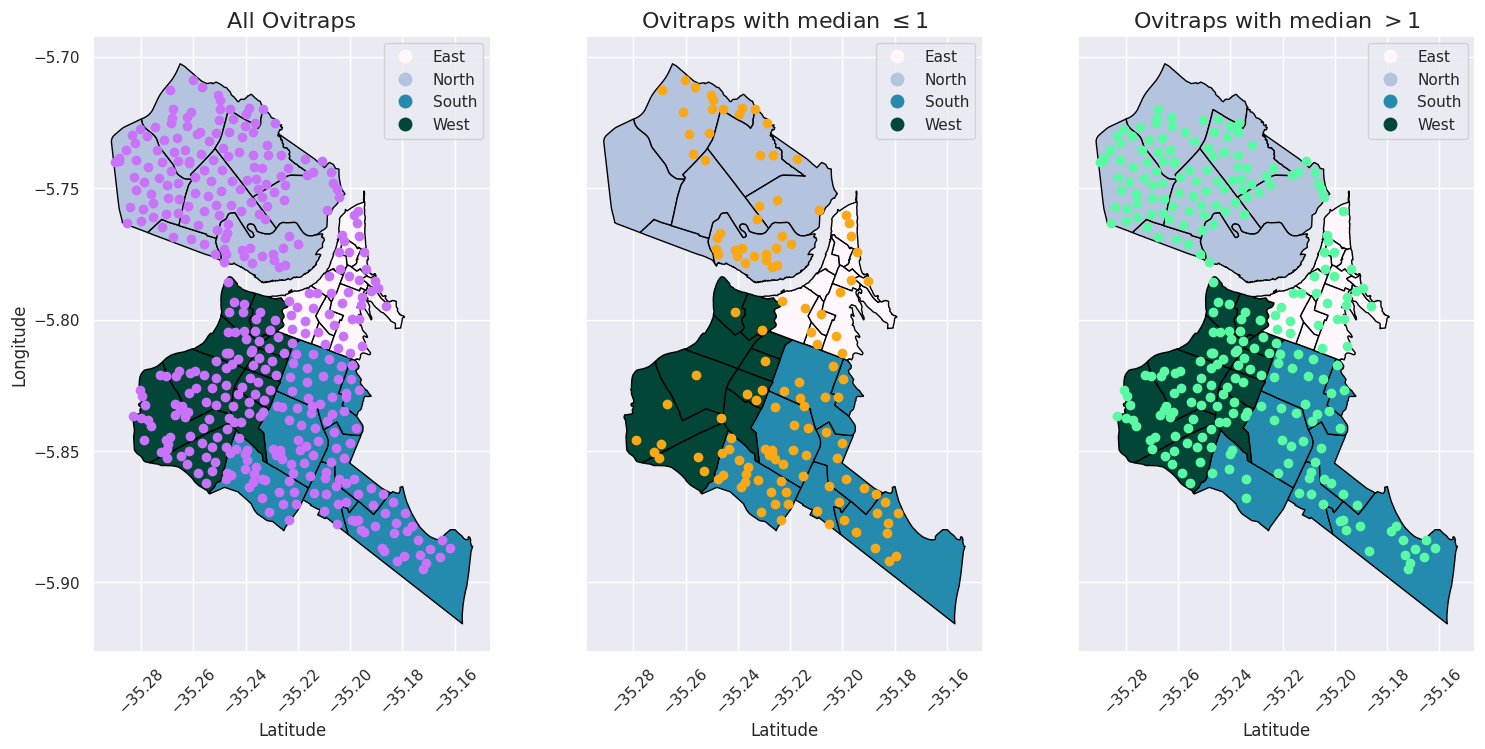

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

natal.plot(
  column="District",
  ax=ax[0],
  edgecolor="black",
  cmap=cmap,
  legend=True
).scatter(
  x=locations_df["Long"],
  y=locations_df["Lat"],
  color="#C973FA"
)

natal.plot(
  column="District",
  ax=ax[1],
  edgecolor="black",
  cmap=cmap,
  legend=True
).scatter(
  x=locations_df.iloc[~I, :]["Long"],
  y=locations_df.iloc[~I, :]["Lat"],
  color="#FAA815"
)

natal.plot(
  column="District",
  ax=ax[2],
  edgecolor="black",
  cmap=cmap,
  legend=True
).scatter(
  x=locations_df.iloc[I, :]["Long"],
  y=locations_df.iloc[I, :]["Lat"],
  color="#5AFAA5"
)

ax[0].set_title("All Ovitraps", fontsize=16)
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_ylabel("Longitude")
ax[0].set_xlabel("Latitude")

ax[1].set_title("Ovitraps with median $\leq  1$", fontsize=16)
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].set_xlabel("Latitude")

ax[2].set_title("Ovitraps with median $> 1$", fontsize=16)
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].set_xlabel("Latitude")

plt.show()

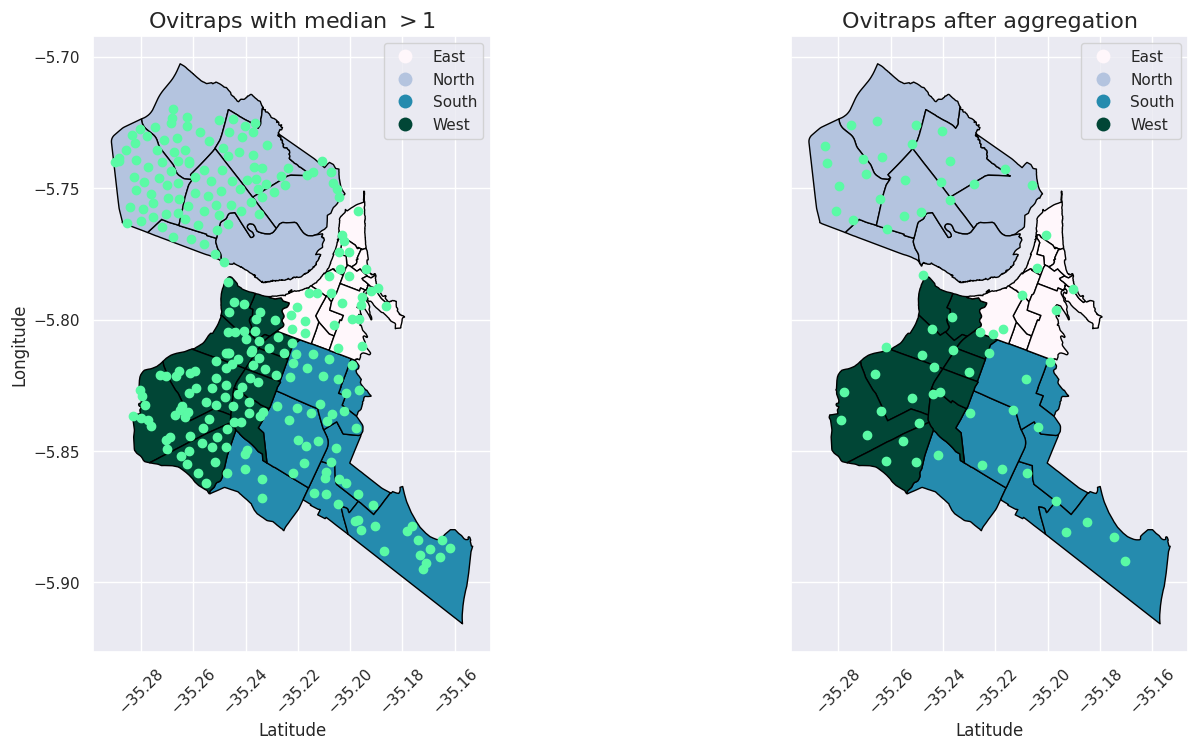

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

natal.plot(
  column="District",
  ax=ax[0],
  cmap=cmap,
  edgecolor="black",
  legend=True
).scatter(
  x=locations_df.iloc[I, :]["Long"],
  y=locations_df.iloc[I, :]["Lat"],
  color="#5AFAA5"
)

natal.plot(
  column="District",
  ax=ax[1],
  cmap=cmap,
  edgecolor="black",
  legend=True
).scatter(
  x=Cent[:,1],
  y=Cent[:,0],
  color="#5AFAA5"
)

ax[0].set_title("Ovitraps with median $> 1$", fontsize=16)
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_ylabel("Longitude")
ax[0].set_xlabel("Latitude")

ax[1].set_title("Ovitraps after aggregation", fontsize=16)
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].set_xlabel("Latitude")

plt.subplots_adjust(wspace=0)
plt.show()

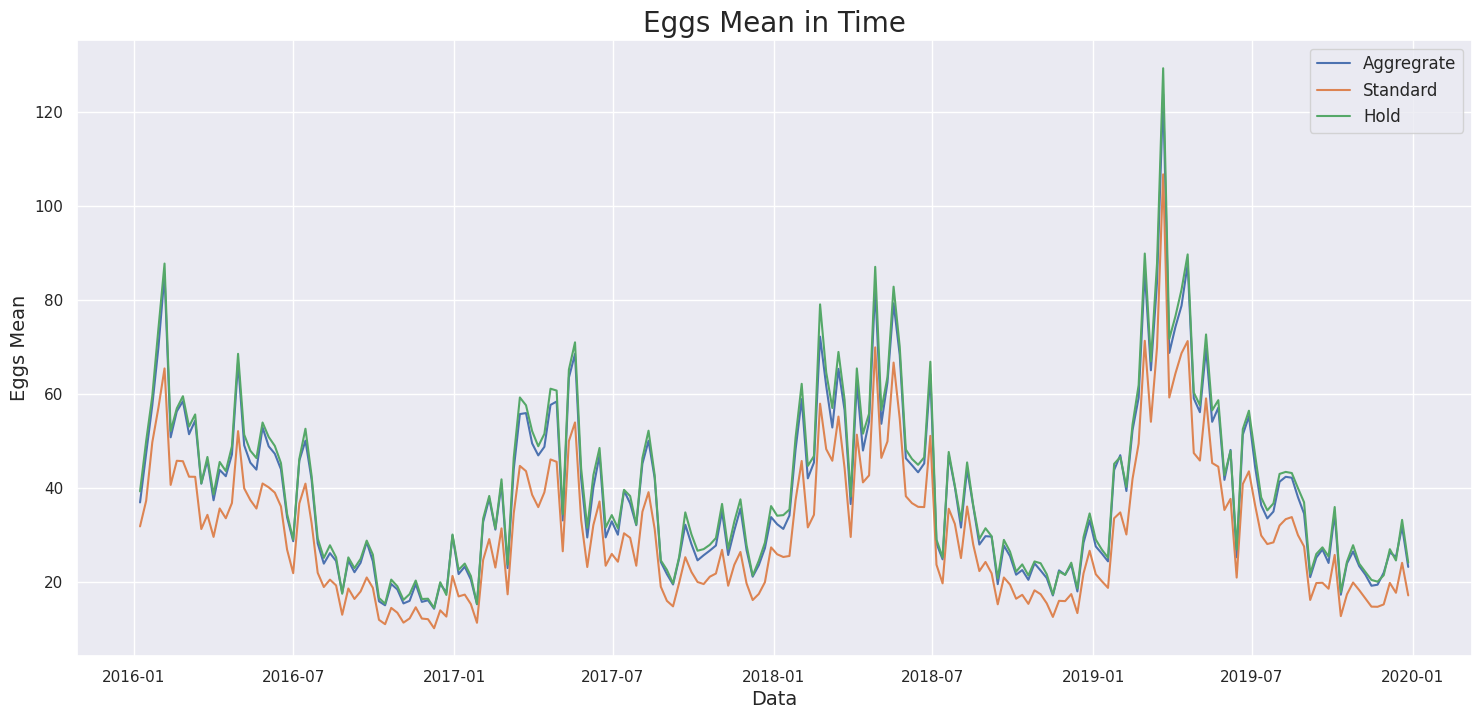

In [ ]:
sns.lineplot(x=ovitraps_series_agg.index, y=ovitraps_series_agg.values, label="Aggregrate")
sns.lineplot(x=ovitraps_series.index, y=ovitraps_series.values, label="Standard")
sns.lineplot(x=ovitraps_series_hold.index, y=ovitraps_series_hold.values, label="Hold")

plt.title("Eggs Mean in Time", fontsize=20)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Eggs Mean", fontsize=14)
plt.legend(fontsize=12)

plt.show()

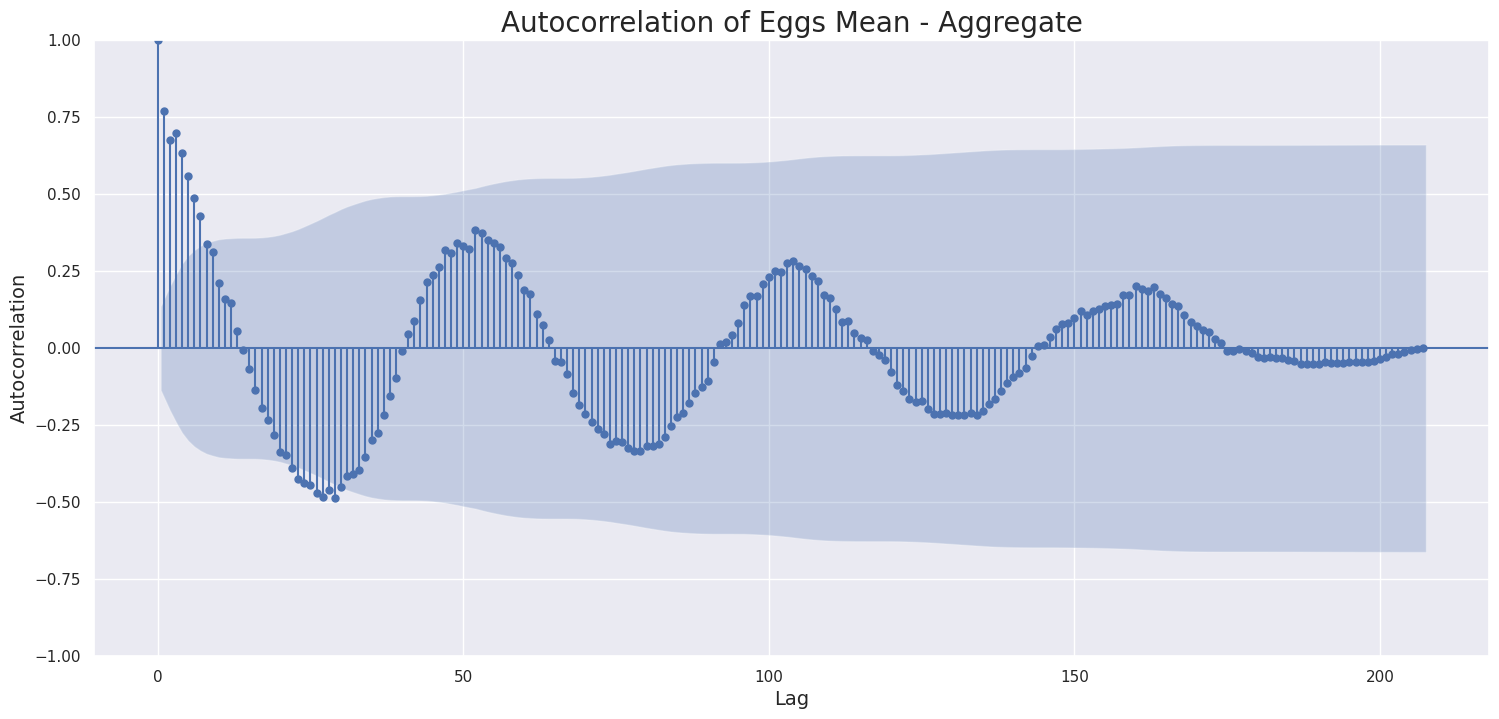

In [ ]:
plot_acf(ovitraps_series_agg, lags=207)

plt.title("Autocorrelation of Eggs Mean - Aggregate", fontsize=20)
plt.xlabel("Lag", fontsize=14)
plt.ylabel("Autocorrelation", fontsize=14)

plt.show()

# 8.0. Training Models

## 8.1. Create Data to Train and Test

In [ ]:
ovitraps_matrix_agg = pd.read_csv(path_eggs_data + "ovitraps_matrix_agg.csv")

ovitraps_matrix_agg

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,19.468750,16.890625,16.750000,10.085938,23.109375,82.375000,55.875000,63.906250,37.531250,44.000000,...,46.312500,16.609375,1.619141,8.625000,32.906250,58.343750,54.062500,29.640625,31.68750,20.93750
1,57.718750,33.593750,25.468750,16.281250,20.265625,35.250000,30.640625,34.281250,49.375000,108.812500,...,103.375000,17.421875,10.953125,32.968750,26.890625,54.937500,40.156250,47.687500,36.15625,39.93750
2,70.687500,35.562500,57.125000,25.953125,32.750000,62.312500,25.218750,45.468750,82.500000,103.187500,...,101.625000,28.203125,27.421875,36.000000,29.781250,52.625000,53.531250,81.687500,48.15625,53.31250
3,70.375000,62.062500,66.937500,38.125000,58.875000,53.656250,87.187500,70.437500,66.250000,70.562500,...,73.875000,22.703125,24.578125,32.718750,31.000000,117.750000,79.437500,88.625000,53.53125,44.37500
4,82.250000,47.500000,60.500000,53.250000,85.500000,56.625000,79.250000,44.656250,72.437500,52.187500,...,150.125000,63.562500,51.125000,45.250000,87.500000,127.625000,68.500000,127.187500,59.68750,59.75000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,30.343750,80.250000,46.500000,73.437500,56.218750,29.625000,29.031250,66.062500,18.781250,16.281250,...,4.359375,15.187500,7.078125,10.515625,25.265625,19.984375,14.515625,35.375000,46.56250,35.34375
204,29.906250,110.000000,17.046875,31.875000,32.187500,28.515625,8.960938,64.000000,25.187500,17.890625,...,6.597656,34.031250,23.765625,37.500000,59.000000,29.921875,6.523438,51.312500,43.96875,32.21875
205,33.468750,29.218750,30.562500,16.218750,16.562500,18.859375,22.750000,35.562500,14.656250,17.312500,...,16.437500,21.312500,13.937500,8.835938,19.687500,35.000000,19.750000,79.875000,50.43750,65.50000
206,19.406250,39.000000,14.890625,14.164062,17.781250,21.562500,23.312500,66.312500,21.531250,29.656250,...,13.257812,16.750000,21.015625,13.953125,26.406250,42.437500,26.500000,107.375000,95.31250,110.50000


In [ ]:
matrix_data = ovitraps_matrix_agg[: int(ovitraps_matrix_agg.shape[0] * 0.8)].T

matrix_data

,0,1,2,3,4,5,6,7,8,9,...,156,157,158,159,160,161,162,163,164,165
0,19.468750,57.718750,70.687500,70.37500,82.2500,55.59375,81.937500,47.625000,59.218750,62.406250,...,21.375000,36.437500,27.187500,51.06250,99.312500,45.84375,86.06250,56.750000,142.87500,75.68750
1,16.890625,33.593750,35.562500,62.06250,47.5000,76.25000,31.765625,48.000000,24.968750,44.562500,...,55.375000,66.500000,36.937500,66.25000,40.937500,36.87500,44.65625,27.265625,90.25000,89.00000
2,16.750000,25.468750,57.125000,66.93750,60.5000,27.40625,44.718750,34.718750,26.812500,45.937500,...,20.031250,30.218750,35.812500,43.09375,132.250000,66.87500,141.75000,100.062500,130.62500,66.56250
3,10.085938,16.281250,25.953125,38.12500,53.2500,29.12500,33.250000,24.609375,15.804688,18.953125,...,25.609375,36.468750,33.812500,59.15625,89.187500,49.12500,177.75000,113.187500,159.00000,44.37500
4,23.109375,20.265625,32.750000,58.87500,85.5000,54.87500,28.796875,22.296875,15.601562,25.046875,...,30.109375,52.375000,32.062500,84.50000,53.531250,37.18750,146.75000,87.937500,89.12500,55.21875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,58.343750,54.937500,52.625000,117.75000,127.6250,46.18750,58.562500,103.750000,52.468750,114.750000,...,45.187500,37.687500,30.296875,32.87500,39.468750,38.71875,38.78125,63.281250,121.56250,80.81250
63,54.062500,40.156250,53.531250,79.43750,68.5000,61.53125,35.593750,43.000000,52.468750,104.250000,...,31.171875,18.843750,24.828125,25.59375,57.375000,37.37500,62.46875,56.937500,92.00000,50.56250
64,29.640625,47.687500,81.687500,88.62500,127.1875,65.12500,88.750000,113.687500,55.343750,72.875000,...,38.343750,23.500000,26.109375,67.75000,37.906250,46.50000,56.65625,56.906250,49.81250,84.62500
65,31.687500,36.156250,48.156250,53.53125,59.6875,44.25000,37.406250,45.437500,29.562500,29.703125,...,48.218750,26.984375,15.195312,40.62500,38.500000,22.34375,40.18750,51.093750,43.78125,43.75000


In [ ]:
error_dataframe = pd.DataFrame()

### 8.1.1. Creating Random Series

In [ ]:
NUMBER_OF_SERIES = 10
NUMBER_OF_POINTS = 40
WEEK_SHIFT       = 5
NUM_EPOCHS       = 200

random_dataframe = pd.DataFrame()

In [ ]:
for i in range(NUMBER_OF_SERIES):
  random_series = pd.DataFrame(create_random_series(matrix_data, NUMBER_OF_POINTS))

  random_dataframe = pd.concat([random_dataframe, random_series], axis=1, ignore_index=True)

In [ ]:
random_dataframe

,0,1,2,3,4,5,6,7,8,9
0,37.231104,37.393359,35.524854,38.970312,38.655273,38.610986,32.861182,35.672314,37.439453,38.019971
1,48.223438,49.737109,42.173437,47.237891,48.452734,53.230859,44.211328,49.310938,51.610547,43.640234
2,55.756055,60.104883,54.711914,56.600000,57.743945,61.551563,53.411523,57.183008,61.801953,57.910547
3,65.426953,69.662109,65.136719,70.354687,72.684766,77.471094,62.392969,68.475000,72.990625,70.083594
4,83.874609,86.125781,81.039844,87.522266,90.374609,89.157813,79.869922,82.690625,89.314844,87.152344
...,...,...,...,...,...,...,...,...,...,...
161,36.329492,41.220312,39.049805,37.565820,39.323242,40.065039,39.203711,39.592773,41.606641,40.904297
162,50.947656,57.073047,48.669531,57.064844,50.798047,51.472266,50.106641,48.126172,54.939453,59.277344
163,58.824219,58.330469,58.882812,61.378516,57.428125,59.599609,57.474609,57.998828,61.249609,63.323047
164,85.675000,85.835156,79.670312,86.017969,84.508594,87.255469,83.377344,87.033594,87.824219,85.881250


## 8.2. MLP (Multilayer Perceptron)

### 8.2.1. Model 1

In [ ]:
for column in random_dataframe.columns:
  random_series = random_dataframe.iloc[:, column]
  input, target = create_dataset(random_series, WEEK_SHIFT)

  X_train, X_test, y_train, y_test = split_train_test(input, target, train_size=0.8)

  mlp_model_1 = keras.Sequential([
      layers.Dense(8, input_dim=X_train.shape[1], kernel_initializer="random_uniform", use_bias=True, activation="linear"),
      layers.Dense(16, kernel_initializer="random_uniform", use_bias=True, activation="sigmoid"),
      layers.Dense(1, kernel_initializer="random_uniform", use_bias=True, activation="linear"),
  ], name="mlp_model_1")

  mlp_model_1.compile(loss="mse", optimizer="adam")

  result = mlp_model_1.fit(X_train, y_train, epochs=NUM_EPOCHS)

  y_pred = result.model.predict(X_test)

  error_dataframe.loc[result.model.name, f"MAE_{column}"] = mean_absolute_error(y_test, y_pred)
  error_dataframe.loc[result.model.name, f"RMSE_{column}"] = np.sqrt(mean_squared_error(y_test, y_pred))

Epoch 1/200
5/5 [==============================] - 1s 7ms/step - loss: 1765.6433
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 1761.4052
Epoch 3/200
5/5 [==============================] - 0s 5ms/step - loss: 1756.8927
Epoch 4/200
5/5 [==============================] - 0s 5ms/step - loss: 1751.6852
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 1745.9163
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 1739.4309
Epoch 7/200
5/5 [==============================] - 0s 6ms/step - loss: 1732.7303
Epoch 8/200
5/5 [==============================] - 0s 4ms/step - loss: 1725.9520
Epoch 9/200
5/5 [==============================] - 0s 4ms/step - loss: 1719.1144
Epoch 10/200
5/5 [==============================] - 0s 4ms/step - loss: 1712.1730
Epoch 11/200
5/5 [==============================] - 0s 6ms/step - loss: 1705.4288
Epoch 12/200
5/5 [==============================] - 0s 4ms/step - loss: 1698.5543
Epoch 13/200
5/5 [=======

2/2 [==============================] - 0s 5ms/step
Epoch 1/200
5/5 [==============================] - 1s 5ms/step - loss: 1806.1166
Epoch 2/200
5/5 [==============================] - 0s 5ms/step - loss: 1801.5742
Epoch 3/200
5/5 [==============================] - 0s 5ms/step - loss: 1796.7839
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 1791.4196
Epoch 5/200
5/5 [==============================] - 0s 5ms/step - loss: 1785.6422
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 1779.3046
Epoch 7/200
5/5 [==============================] - 0s 5ms/step - loss: 1772.8987
Epoch 8/200
5/5 [==============================] - 0s 4ms/step - loss: 1766.6027
Epoch 9/200
5/5 [==============================] - 0s 5ms/step - loss: 1760.4241
Epoch 10/200
5/5 [==============================] - 0s 4ms/step - loss: 1754.2114
Epoch 11/200
5/5 [==============================] - 0s 4ms/step - loss: 1747.9916
Epoch 12/200
5/5 [==============================] - 0s 4

2/2 [==============================] - 0s 4ms/step
Epoch 1/200
5/5 [==============================] - 2s 5ms/step - loss: 1645.9264
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 1641.2911
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 1636.4010
Epoch 4/200
5/5 [==============================] - 0s 5ms/step - loss: 1631.1265
Epoch 5/200
5/5 [==============================] - 0s 5ms/step - loss: 1625.8163
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 1620.4070
Epoch 7/200
5/5 [==============================] - 0s 4ms/step - loss: 1615.2239
Epoch 8/200
5/5 [==============================] - 0s 4ms/step - loss: 1610.1912
Epoch 9/200
5/5 [==============================] - 0s 4ms/step - loss: 1605.1141
Epoch 10/200
5/5 [==============================] - 0s 4ms/step - loss: 1599.8186
Epoch 11/200
5/5 [==============================] - 0s 4ms/step - loss: 1594.6178
Epoch 12/200
5/5 [==============================] - 0s 4

### 8.2.2. Model 2

In [ ]:
for column in random_dataframe.columns:
  random_series = random_dataframe.iloc[:, column]
  input, target = create_dataset(random_series, WEEK_SHIFT)

  X_train, X_test, y_train, y_test = split_train_test(input, target, train_size=0.8)

  mlp_model_2 = keras.Sequential([
      layers.Dense(8, input_dim=X_train.shape[1], kernel_initializer="random_uniform", use_bias=True, activation="linear"),
      layers.Dense(32, kernel_initializer="random_uniform", use_bias=True, activation="sigmoid"),
      layers.Dense(1, kernel_initializer="random_uniform", use_bias=True, activation="linear"),
  ], name="mlp_model_2")

  mlp_model_2.compile(loss="mse", optimizer="adam")

  result = mlp_model_2.fit(X_train, y_train, epochs=NUM_EPOCHS)

  y_pred = result.model.predict(X_test)

  error_dataframe.loc[result.model.name, f"MAE_{column}"] = mean_absolute_error(y_test, y_pred)
  error_dataframe.loc[result.model.name, f"RMSE_{column}"] = np.sqrt(mean_squared_error(y_test, y_pred))

Epoch 1/200
5/5 [==============================] - 1s 5ms/step - loss: 1758.8500
Epoch 2/200
5/5 [==============================] - 0s 5ms/step - loss: 1750.6044
Epoch 3/200
5/5 [==============================] - 0s 5ms/step - loss: 1741.6309
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 1731.2319
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 1719.6323
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 1706.4390
Epoch 7/200
5/5 [==============================] - 0s 4ms/step - loss: 1692.6824
Epoch 8/200
5/5 [==============================] - 0s 3ms/step - loss: 1678.6655
Epoch 9/200
5/5 [==============================] - 0s 4ms/step - loss: 1664.5088
Epoch 10/200
5/5 [==============================] - 0s 4ms/step - loss: 1650.2042
Epoch 11/200
5/5 [==============================] - 0s 4ms/step - loss: 1636.4518
Epoch 12/200
5/5 [==============================] - 0s 4ms/step - loss: 1622.6501
Epoch 13/200
5/5 [=======

## 8.3. LSTM (Long-Short Therm Memory)

### 8.3.1. LSTM 1

In [ ]:
for column in random_dataframe.columns:
  random_series = random_dataframe.iloc[:, column]
  input, target = create_dataset(random_series, WEEK_SHIFT)

  X_train, X_test, y_train, y_test = split_train_test(input, target, train_size=0.8)

  lstm_model_1 = keras.Sequential([
      layers.LSTM(32, input_shape=(X_train.shape[1], 1), use_bias=True, activation="relu"),
      layers.Dense(1, kernel_initializer="random_uniform", use_bias=True, activation="linear")
  ], name="lstm_model_1")

  lstm_model_1.compile(loss="mse", optimizer="adam")

  result = lstm_model_1.fit(X_train, y_train, epochs=NUM_EPOCHS)

  y_pred = result.model.predict(X_test)

  error_dataframe.loc[result.model.name, f"MAE_{column}"] = mean_absolute_error(y_test, y_pred)
  error_dataframe.loc[result.model.name, f"RMSE_{column}"] = np.sqrt(mean_squared_error(y_test, y_pred))

Epoch 1/200
5/5 [==============================] - 2s 8ms/step - loss: 1783.2347
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 1740.2430
Epoch 3/200
5/5 [==============================] - 0s 8ms/step - loss: 1699.1155
Epoch 4/200
5/5 [==============================] - 0s 8ms/step - loss: 1653.8323
Epoch 5/200
5/5 [==============================] - 0s 8ms/step - loss: 1602.1675
Epoch 6/200
5/5 [==============================] - 0s 7ms/step - loss: 1535.6659
Epoch 7/200
5/5 [==============================] - 0s 7ms/step - loss: 1453.0972
Epoch 8/200
5/5 [==============================] - 0s 8ms/step - loss: 1337.1478
Epoch 9/200
5/5 [==============================] - 0s 8ms/step - loss: 1152.4436
Epoch 10/200
5/5 [==============================] - 0s 8ms/step - loss: 782.6771
Epoch 11/200
5/5 [==============================] - 0s 7ms/step - loss: 345.6812
Epoch 12/200
5/5 [==============================] - 0s 7ms/step - loss: 193.8732
Epoch 13/200
5/5 [==========

### 8.3.2. Model 2

In [ ]:
for column in random_dataframe.columns:
  random_series = random_dataframe.iloc[:, column]
  input, target = create_dataset(random_series, WEEK_SHIFT)

  X_train, X_test, y_train, y_test = split_train_test(input, target, train_size=0.8)

  lstm_model_2 = keras.Sequential([
      layers.LSTM(128, input_shape=(X_train.shape[1], 1), use_bias=True, activation="relu"),
      layers.Dense(1, kernel_initializer="random_uniform", use_bias=True, activation="linear")
  ], name="lstm_model_2")

  lstm_model_2.compile(loss="mse", optimizer="adam")

  result = lstm_model_2.fit(X_train, y_train, epochs=NUM_EPOCHS)

  y_pred = result.model.predict(X_test)

  error_dataframe.loc[result.model.name, f"MAE_{column}"] = mean_absolute_error(y_test, y_pred)
  error_dataframe.loc[result.model.name, f"RMSE_{column}"] = np.sqrt(mean_squared_error(y_test, y_pred))

Epoch 1/200
5/5 [==============================] - 2s 19ms/step - loss: 1771.2292
Epoch 2/200
5/5 [==============================] - 0s 15ms/step - loss: 1592.5895
Epoch 3/200
5/5 [==============================] - 0s 13ms/step - loss: 1358.2809
Epoch 4/200
5/5 [==============================] - 0s 14ms/step - loss: 868.5893
Epoch 5/200
5/5 [==============================] - 0s 12ms/step - loss: 248.2902
Epoch 6/200
5/5 [==============================] - 0s 14ms/step - loss: 454.0618
Epoch 7/200
5/5 [==============================] - 0s 12ms/step - loss: 348.3903
Epoch 8/200
5/5 [==============================] - 0s 13ms/step - loss: 144.5911
Epoch 9/200
5/5 [==============================] - 0s 13ms/step - loss: 191.6399
Epoch 10/200
5/5 [==============================] - 0s 13ms/step - loss: 222.2787
Epoch 11/200
5/5 [==============================] - 0s 15ms/step - loss: 187.7510
Epoch 12/200
5/5 [==============================] - 0s 13ms/step - loss: 140.9210
Epoch 13/200
5/5 [====

### 8.3.3. Model 3

In [ ]:
for column in random_dataframe.columns:
  random_series = random_dataframe.iloc[:, column]
  input, target = create_dataset(random_series, WEEK_SHIFT)

  X_train, X_test, y_train, y_test = split_train_test(input, target, train_size=0.8)

  lstm_model_3 = keras.Sequential([
      layers.LSTM(128, input_shape=(X_train.shape[1], 1), use_bias=True, activation="relu", return_sequences=True),
      layers.LSTM(128, use_bias=True, activation="relu"),
      layers.Dense(1, kernel_initializer="random_uniform", use_bias=True, activation="linear")
  ], name="lstm_model_3")

  lstm_model_3.compile(loss="mse", optimizer="adam")

  result = lstm_model_3.fit(X_train, y_train, epochs=NUM_EPOCHS)

  y_pred = result.model.predict(X_test)

  error_dataframe.loc[result.model.name, f"MAE_{column}"] = mean_absolute_error(y_test, y_pred)
  error_dataframe.loc[result.model.name, f"RMSE_{column}"] = np.sqrt(mean_squared_error(y_test, y_pred))

Epoch 1/200
5/5 [==============================] - 6s 43ms/step - loss: 1720.2944
Epoch 2/200
5/5 [==============================] - 0s 30ms/step - loss: 1483.0745
Epoch 3/200
5/5 [==============================] - 0s 29ms/step - loss: 755.7864
Epoch 4/200
5/5 [==============================] - 0s 32ms/step - loss: 410.2937
Epoch 5/200
5/5 [==============================] - 0s 30ms/step - loss: 200.5201
Epoch 6/200
5/5 [==============================] - 0s 34ms/step - loss: 217.7316
Epoch 7/200
5/5 [==============================] - 0s 31ms/step - loss: 180.2665
Epoch 8/200
5/5 [==============================] - 0s 34ms/step - loss: 158.5992
Epoch 9/200
5/5 [==============================] - 0s 29ms/step - loss: 154.1878
Epoch 10/200
5/5 [==============================] - 0s 32ms/step - loss: 156.5760
Epoch 11/200
5/5 [==============================] - 0s 38ms/step - loss: 171.3510
Epoch 12/200
5/5 [==============================] - 0s 37ms/step - loss: 145.2213
Epoch 13/200
5/5 [=====

## 8.4. GRU (Gated Recurrent Unity)

### 8.4.1. Model 1

In [ ]:
for column in random_dataframe.columns:
  random_series = random_dataframe.iloc[:, column]
  input, target = create_dataset(random_series, WEEK_SHIFT)

  X_train, X_test, y_train, y_test = split_train_test(input, target, train_size=0.8)

  gru_model_1 = keras.Sequential([
      layers.GRU(32, input_shape=(X_train.shape[1], 1), use_bias=True, activation="relu"),
      layers.Dense(1, kernel_initializer="random_uniform", use_bias=True, activation="linear")
  ], name="gru_model_1")

  gru_model_1.compile(loss="mse", optimizer="adam")

  result = gru_model_1.fit(X_train, y_train, epochs=NUM_EPOCHS)

  y_pred = result.model.predict(X_test)

  error_dataframe.loc[result.model.name, f"MAE_{column}"] = mean_absolute_error(y_test, y_pred)
  error_dataframe.loc[result.model.name, f"RMSE_{column}"] = np.sqrt(mean_squared_error(y_test, y_pred))

Epoch 1/200
5/5 [==============================] - 2s 6ms/step - loss: 1850.9149
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 1819.5782
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 1789.6925
Epoch 4/200
5/5 [==============================] - 0s 5ms/step - loss: 1756.7565
Epoch 5/200
5/5 [==============================] - 0s 5ms/step - loss: 1718.9966
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 1670.8719
Epoch 7/200
5/5 [==============================] - 0s 6ms/step - loss: 1612.1055
Epoch 8/200
5/5 [==============================] - 0s 6ms/step - loss: 1534.8866
Epoch 9/200
5/5 [==============================] - 0s 6ms/step - loss: 1432.1605
Epoch 10/200
5/5 [==============================] - 0s 5ms/step - loss: 1282.4309
Epoch 11/200
5/5 [==============================] - 0s 6ms/step - loss: 1072.1040
Epoch 12/200
5/5 [==============================] - 0s 6ms/step - loss: 790.1994
Epoch 13/200
5/5 [========

### 8.4.2. Model 2

In [ ]:
for column in random_dataframe.columns:
  random_series = random_dataframe.iloc[:, column]
  input, target = create_dataset(random_series, WEEK_SHIFT)

  X_train, X_test, y_train, y_test = split_train_test(input, target, train_size=0.8)

  gru_model_2 = keras.Sequential([
      layers.GRU(128, input_shape=(X_train.shape[1], 1), use_bias=True, activation="relu"),
      layers.Dense(1, kernel_initializer="random_uniform", use_bias=True, activation="linear")
  ], name="gru_model_2")

  gru_model_2.compile(loss="mse", optimizer="adam")

  result = gru_model_2.fit(X_train, y_train, epochs=NUM_EPOCHS)

  y_pred = result.model.predict(X_test)

  error_dataframe.loc[result.model.name, f"MAE_{column}"] = mean_absolute_error(y_test, y_pred)
  error_dataframe.loc[result.model.name, f"RMSE_{column}"] = np.sqrt(mean_squared_error(y_test, y_pred))

Epoch 1/200
5/5 [==============================] - 2s 10ms/step - loss: 1693.2394
Epoch 2/200
5/5 [==============================] - 0s 11ms/step - loss: 1581.4418
Epoch 3/200
5/5 [==============================] - 0s 10ms/step - loss: 1430.8356
Epoch 4/200
5/5 [==============================] - 0s 10ms/step - loss: 1180.3169
Epoch 5/200
5/5 [==============================] - 0s 11ms/step - loss: 793.9301
Epoch 6/200
5/5 [==============================] - 0s 11ms/step - loss: 344.3052
Epoch 7/200
5/5 [==============================] - 0s 10ms/step - loss: 141.7681
Epoch 8/200
5/5 [==============================] - 0s 10ms/step - loss: 262.9688
Epoch 9/200
5/5 [==============================] - 0s 11ms/step - loss: 149.8162
Epoch 10/200
5/5 [==============================] - 0s 11ms/step - loss: 152.0087
Epoch 11/200
5/5 [==============================] - 0s 11ms/step - loss: 183.7405
Epoch 12/200
5/5 [==============================] - 0s 10ms/step - loss: 157.9581
Epoch 13/200
5/5 [===

### 8.4.3. Model 3

In [ ]:
for column in random_dataframe.columns:
  random_series = random_dataframe.iloc[:, column]
  input, target = create_dataset(random_series, WEEK_SHIFT)

  X_train, X_test, y_train, y_test = split_train_test(input, target, train_size=0.8)

  gru_model_3 = keras.Sequential([
      layers.GRU(128, input_shape=(X_train.shape[1], 1), use_bias=True, activation="relu", return_sequences=True),
      layers.GRU(128, use_bias=True, activation="relu"),
      layers.Dense(1, kernel_initializer="random_uniform", use_bias=True, activation="linear")
  ], name="gru_model_3")

  gru_model_3.compile(loss="mse", optimizer="adam")

  result = gru_model_3.fit(X_train, y_train, epochs=NUM_EPOCHS)

  y_pred = result.model.predict(X_test)

  error_dataframe.loc[result.model.name, f"MAE_{column}"] = mean_absolute_error(y_test, y_pred)
  error_dataframe.loc[result.model.name, f"RMSE_{column}"] = np.sqrt(mean_squared_error(y_test, y_pred))

Epoch 1/200
5/5 [==============================] - 3s 12ms/step - loss: 1704.9990
Epoch 2/200
5/5 [==============================] - 0s 14ms/step - loss: 1533.3529
Epoch 3/200
5/5 [==============================] - 0s 13ms/step - loss: 1219.4626
Epoch 4/200
5/5 [==============================] - 0s 11ms/step - loss: 565.3856
Epoch 5/200
5/5 [==============================] - 0s 16ms/step - loss: 240.1566
Epoch 6/200
5/5 [==============================] - 0s 11ms/step - loss: 326.4966
Epoch 7/200
5/5 [==============================] - 0s 13ms/step - loss: 150.0097
Epoch 8/200
5/5 [==============================] - 0s 15ms/step - loss: 138.4504
Epoch 9/200
5/5 [==============================] - 0s 12ms/step - loss: 167.3055
Epoch 10/200
5/5 [==============================] - 0s 12ms/step - loss: 144.7453
Epoch 11/200
5/5 [==============================] - 0s 12ms/step - loss: 126.4175
Epoch 12/200
5/5 [==============================] - 0s 12ms/step - loss: 135.5614
Epoch 13/200
5/5 [====

# 9.0. Models Errors

In [ ]:
error_dataframe

,MAE_0,RMSE_0,MAE_1,RMSE_1,MAE_2,RMSE_2,MAE_3,RMSE_3,MAE_4,RMSE_4,MAE_5,RMSE_5,MAE_6,RMSE_6,MAE_7,RMSE_7,MAE_8,RMSE_8,MAE_9,RMSE_9
mlp_model_1,16.336985,21.959585,18.033824,23.625606,16.564268,21.507309,17.109201,22.851362,16.288603,22.031433,17.345855,23.298910,16.635091,21.918725,17.521182,22.799677,18.576655,24.231991,16.930931,23.328497
mlp_model_2,9.901669,15.678121,10.562558,16.821690,9.299570,15.005727,10.418228,16.821285,9.962369,15.609642,10.698641,17.069908,9.608549,15.487692,10.029782,16.128514,10.939682,17.480403,11.058792,17.254481
lstm_model_1,6.601008,10.122816,6.401328,9.474447,6.523310,9.378711,6.449194,10.410957,6.565695,9.469959,6.723168,10.110383,6.372342,9.372787,6.348425,9.856622,7.516533,10.405614,6.666255,10.039467
lstm_model_2,6.255092,9.467112,6.823106,9.453220,6.209607,8.551630,6.939200,10.003055,5.931078,8.728237,6.838465,9.686042,6.264806,8.941061,6.682208,9.748621,7.107756,9.486286,6.242593,9.513445
lstm_model_3,6.853616,9.747702,6.670494,9.279318,6.093212,8.626796,6.220981,10.276505,6.415865,9.332141,6.957588,9.893628,6.122510,8.895891,6.714511,9.727598,7.012020,10.004173,6.403462,9.283217
gru_model_1,6.430278,9.999654,6.281406,9.758975,6.305186,9.156201,6.261677,10.562077,6.525801,10.397750,6.449449,10.124473,5.879494,9.331114,6.212614,9.879598,7.086289,10.052161,6.274622,10.477533
gru_model_2,6.301183,9.352586,6.622362,9.268747,6.269127,8.738875,6.709072,9.615441,6.871999,9.284948,6.883209,9.729514,6.514605,9.166708,6.557504,9.262021,7.233218,9.536771,6.535648,9.486879
gru_model_3,6.936938,9.425253,6.442856,9.175059,6.275255,8.771191,6.439315,9.579380,6.920424,9.348640,6.588499,9.527422,6.556713,9.172671,6.799491,9.415774,7.183956,9.495460,6.879924,9.543147


In [ ]:
error_dataframe.to_csv(path_models_data + "error_dataframe.csv", index=False)

In [ ]:
mae_columns  = [column for column in error_dataframe.columns if "MAE" in column]
rmse_columns = [column for column in error_dataframe.columns if "RMSE" in column]

In [ ]:
mae_mean_error  = error_dataframe[mae_columns].T.mean()
rmse_mean_error = error_dataframe[rmse_columns].T.mean()

mean_error_dataframe = pd.DataFrame({
  "MAE": mae_mean_error,
  "RMSE": rmse_mean_error
}, index = mae_mean_error.index)

mean_error_dataframe

,MAE,RMSE
mlp_model_1,17.134260,22.755309
mlp_model_2,10.247984,16.335746
lstm_model_1,6.616726,9.864177
lstm_model_2,6.529391,9.357871
lstm_model_3,6.546426,9.506697
gru_model_1,6.370682,9.973954
gru_model_2,6.649793,9.344249
gru_model_3,6.702337,9.345400


In [ ]:
mean_error_dataframe.to_csv(path_models_data + "mean_error_dataframe.csv", index=False)

In [ ]:
mean_error_dataframe.sort_values("MAE")

,MAE,RMSE
gru_model_1,6.370682,9.973954
lstm_model_2,6.529391,9.357871
lstm_model_3,6.546426,9.506697
lstm_model_1,6.616726,9.864177
gru_model_2,6.649793,9.344249
gru_model_3,6.702337,9.345400
mlp_model_2,10.247984,16.335746
mlp_model_1,17.134260,22.755309


In [ ]:
mean_error_dataframe.sort_values("RMSE")

,MAE,RMSE
gru_model_2,6.649793,9.344249
gru_model_3,6.702337,9.345400
lstm_model_2,6.529391,9.357871
lstm_model_3,6.546426,9.506697
lstm_model_1,6.616726,9.864177
gru_model_1,6.370682,9.973954
mlp_model_2,10.247984,16.335746
mlp_model_1,17.134260,22.755309


# 10.0. Selecting best models

In [ ]:
input, target = create_dataset(ovitraps_series_agg, WEEK_SHIFT)

X_train, X_test, y_train, y_test = split_train_test(input, target, train_size=0.8)

## 10.1. LSTM

In [ ]:
lstm_model = keras.Sequential([
    layers.LSTM(32, input_shape=(X_train.shape[1], 1), use_bias=True, activation="relu"),
    layers.Dense(1, kernel_initializer="random_uniform", use_bias=True, activation="linear")
], name="lstm_model")

lstm_model.compile(loss="mse", optimizer="adam")

result = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=NUM_EPOCHS)

Epoch 1/200
6/6 [==============================] - 3s 109ms/step - loss: 1784.6774 - val_loss: 2303.2063
Epoch 2/200
6/6 [==============================] - 0s 16ms/step - loss: 1741.4664 - val_loss: 2247.0005
Epoch 3/200
6/6 [==============================] - 0s 16ms/step - loss: 1702.3011 - val_loss: 2194.2397
Epoch 4/200
6/6 [==============================] - 0s 19ms/step - loss: 1662.2170 - val_loss: 2137.0447
Epoch 5/200
6/6 [==============================] - 0s 19ms/step - loss: 1611.6005 - val_loss: 2045.0010
Epoch 6/200
6/6 [==============================] - 0s 18ms/step - loss: 1506.7083 - val_loss: 1767.4095
Epoch 7/200
6/6 [==============================] - 0s 17ms/step - loss: 1256.2953 - val_loss: 1198.5826
Epoch 8/200
6/6 [==============================] - 0s 19ms/step - loss: 833.8629 - val_loss: 556.7713
Epoch 9/200
6/6 [==============================] - 0s 16ms/step - loss: 373.7708 - val_loss: 198.8546
Epoch 10/200
6/6 [==============================] - 0s 15ms/step - 

In [ ]:
result.model.save(path_models_data + f"/{result.model.name}")

In [ ]:
y_pred = []

for value in input:
  value = np.array(value)

  y_pred.append(result.model.predict(value.reshape(1, 4))[0][0])

1/1 [==============================] - 0s 32ms/step


In [ ]:
pred_series_by_lstm = pd.DataFrame(y_pred, index=ovitraps_series_agg[4:].index)

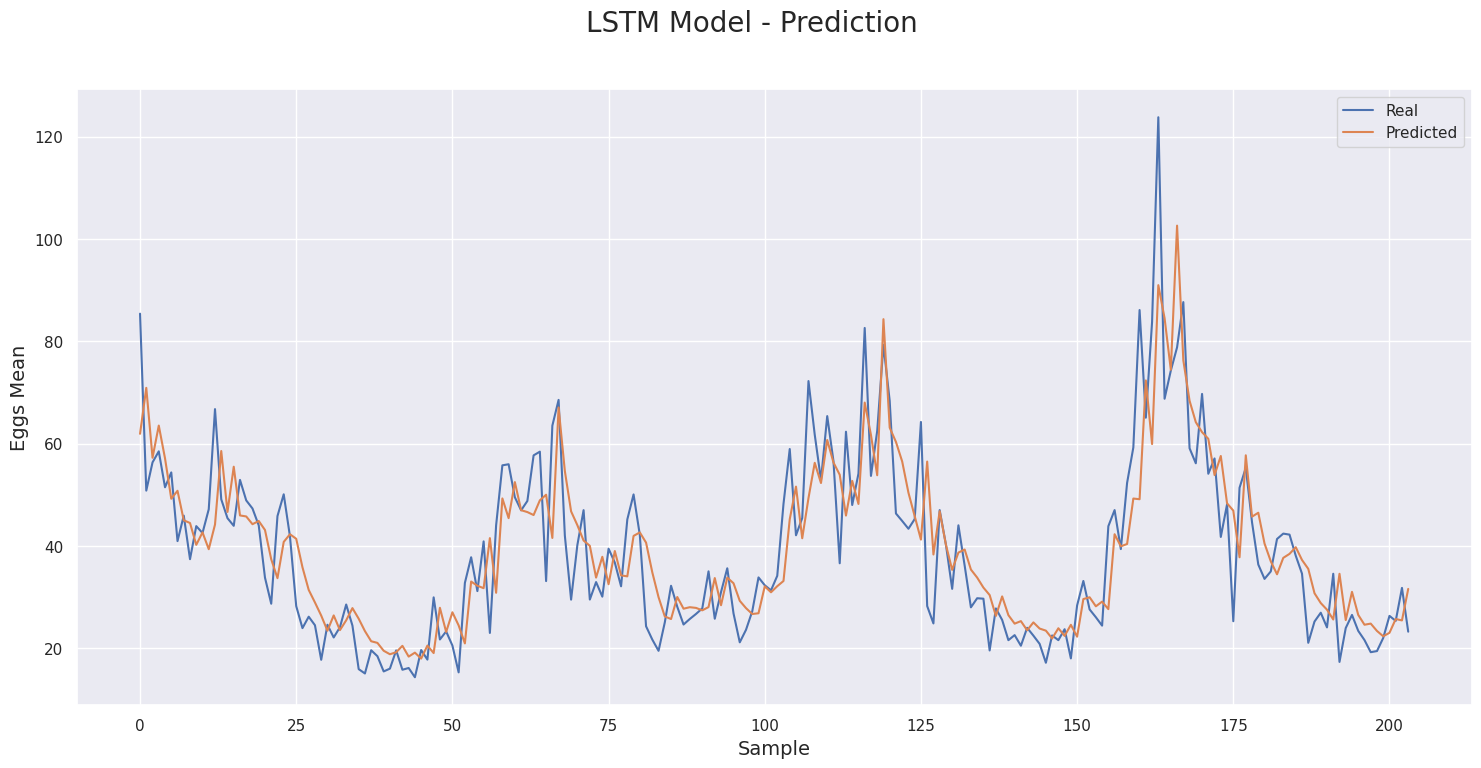

In [ ]:
fig, ax = plt.subplots()

fig.suptitle("LSTM Model - Prediction", fontsize=20)

ax.plot(ovitraps_series_agg[4:].values, label="Real")
ax.plot(y_pred, label="Predicted")

ax.set_ylabel("Eggs Mean", fontsize=14)
ax.set_xlabel("Sample", fontsize=14)

ax.legend()
plt.show()

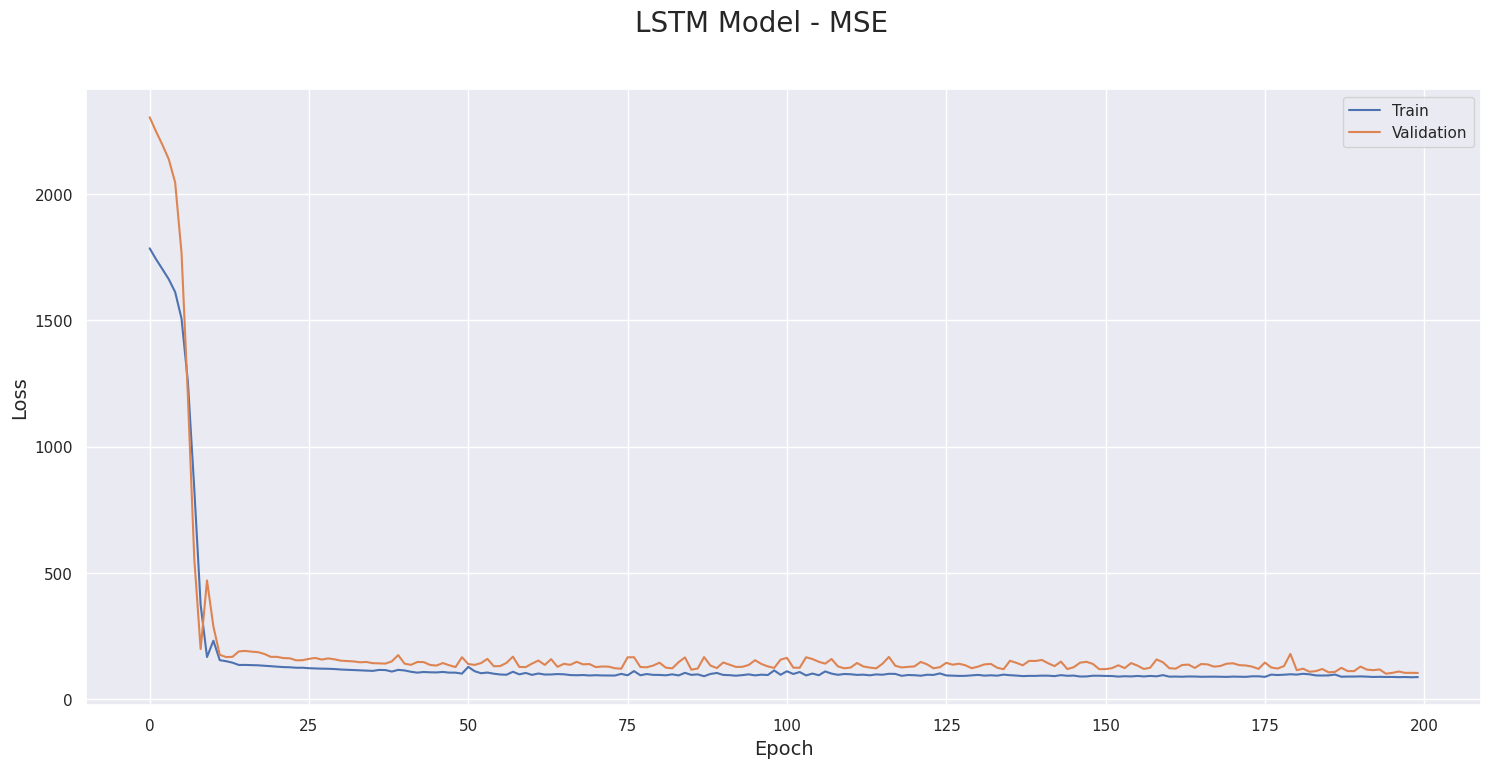

In [ ]:
fig, ax = plt.subplots()

fig.suptitle("LSTM Model - MSE", fontsize=20)

ax.plot(result.history["loss"], label="Train")
ax.plot(result.history["val_loss"], label="Validation")

ax.set_ylabel("Loss", fontsize=14)
ax.set_xlabel("Epoch", fontsize=14)

ax.legend()
plt.show()

## 10.2. GRU

In [ ]:
gru_model = keras.Sequential([
    layers.GRU(32, input_shape=(X_train.shape[1], 1), use_bias=True, activation="relu"),
    layers.Dense(1, kernel_initializer="random_uniform", use_bias=True, activation="linear")
], name="gru_model")

gru_model.compile(loss="mse", optimizer="adam")

result = gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=NUM_EPOCHS)

Epoch 1/200
6/6 [==============================] - 2s 62ms/step - loss: 1716.1837 - val_loss: 2213.1619
Epoch 2/200
6/6 [==============================] - 0s 14ms/step - loss: 1683.6462 - val_loss: 2171.3647
Epoch 3/200
6/6 [==============================] - 0s 14ms/step - loss: 1652.5111 - val_loss: 2128.7029
Epoch 4/200
6/6 [==============================] - 0s 11ms/step - loss: 1619.1765 - val_loss: 2081.1045
Epoch 5/200
6/6 [==============================] - 0s 14ms/step - loss: 1582.3906 - val_loss: 2024.2687
Epoch 6/200
6/6 [==============================] - 0s 11ms/step - loss: 1535.3497 - val_loss: 1948.4425
Epoch 7/200
6/6 [==============================] - 0s 11ms/step - loss: 1471.3361 - val_loss: 1818.7976
Epoch 8/200
6/6 [==============================] - 0s 14ms/step - loss: 1368.2195 - val_loss: 1616.6721
Epoch 9/200
6/6 [==============================] - 0s 12ms/step - loss: 1205.7568 - val_loss: 1355.1974
Epoch 10/200
6/6 [==============================] - 0s 11ms/step

In [ ]:
result.model.save(path_models_data + f"/{result.model.name}")

In [ ]:
y_pred = []

for value in input:
  value = np.array(value)

  y_pred.append(result.model.predict(value.reshape(1, 4))[0][0])

1/1 [==============================] - 0s 29ms/step


In [ ]:
pred_series_by_gru = pd.DataFrame(y_pred, index=ovitraps_series_agg[4:].index)

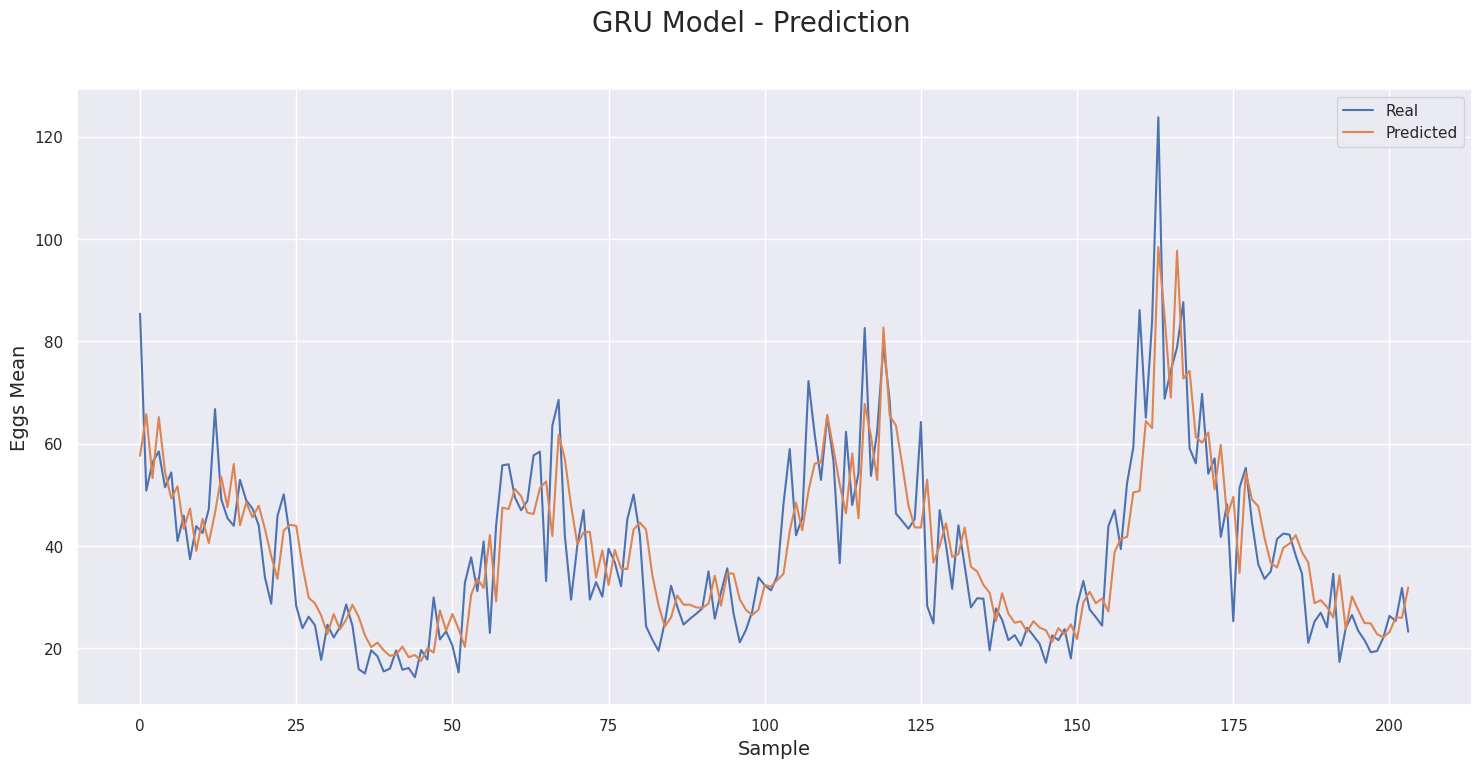

In [ ]:
fig, ax = plt.subplots()

fig.suptitle("GRU Model - Prediction", fontsize=20)

ax.plot(ovitraps_series_agg[4:].values, label="Real")
ax.plot(y_pred, label="Predicted")

ax.set_ylabel("Eggs Mean", fontsize=14)
ax.set_xlabel("Sample", fontsize=14)

ax.legend()
plt.show()

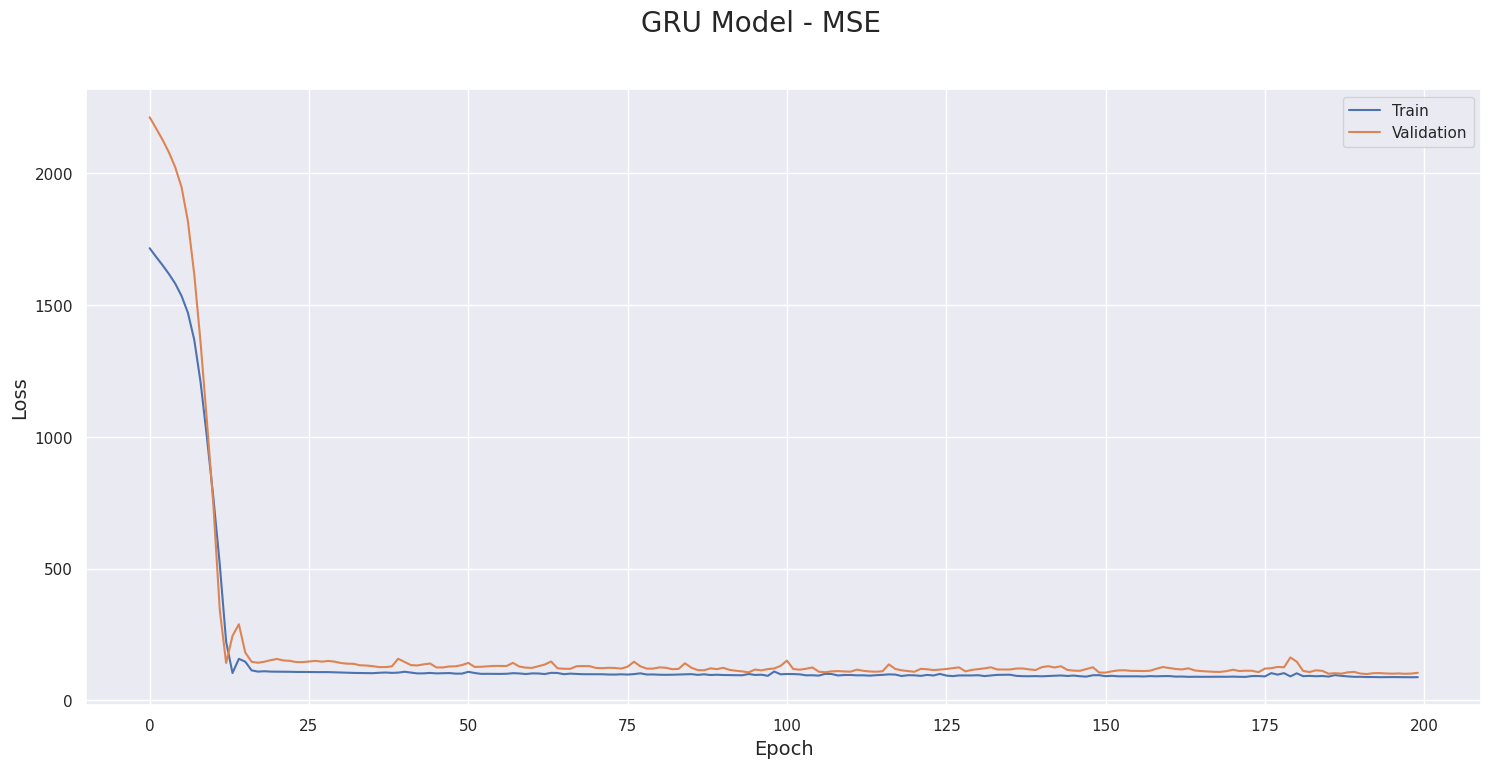

In [ ]:
fig, ax = plt.subplots()

fig.suptitle("GRU Model - MSE", fontsize=20)

ax.plot(result.history["loss"], label="Train")
ax.plot(result.history["val_loss"], label="Validation")

ax.set_ylabel("Loss", fontsize=14)
ax.set_xlabel("Epoch", fontsize=14)

ax.legend()
plt.show()

## 10.3. For Each Ovitrap Aggregated Point

In [ ]:
int(ovitraps_matrix_agg.shape[0] * 0.8)

166

In [ ]:
data_to_predict = ovitraps_matrix_agg.iloc[int(ovitraps_matrix_agg.shape[0] * 0.8):]

data_to_predict.head()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
166,100.12500,117.62500,137.2500,155.875,156.6250,45.75000,61.40625,64.5000,113.25000,37.87500,...,63.9375,68.8750,45.59375,78.7500,82.0625,98.8750,69.00000,98.4375,90.2500,88.3125
167,127.93750,99.62500,154.1250,160.875,155.7500,125.56250,132.25000,122.7500,106.06250,86.12500,...,83.2500,94.6875,98.87500,103.2500,111.3750,209.1250,140.62500,113.6250,121.0000,116.2500
168,41.90625,56.21875,44.1250,58.125,47.1875,63.34375,76.75000,95.6250,54.46875,22.03125,...,70.5000,49.5000,65.68750,65.8750,38.8750,87.1250,68.50000,112.7500,74.6875,74.5000
169,78.37500,72.12500,90.8750,79.125,74.5000,84.37500,87.12500,100.9375,61.62500,43.68750,...,61.4375,88.2500,32.93750,72.8125,174.5000,87.3750,75.62500,107.1875,55.0625,68.6250
170,72.25000,33.37500,79.0625,82.875,49.5625,50.87500,110.62500,144.3750,56.03125,40.46875,...,81.1875,81.9375,83.37500,72.3125,95.8750,98.5625,54.65625,95.8125,100.2500,117.1250


In [ ]:
pred_matrix_by_lstm = pd.DataFrame()
pred_matrix_by_gru  = pd.DataFrame()

for idx_i, col in enumerate(data_to_predict.columns):
  pred_lstm = []
  pred_gru  = []

  input_row, target = create_dataset(data_to_predict[col], WEEK_SHIFT)

  for idx_j, input in enumerate(input_row):
    input = np.array(input)
    input = input.reshape(1, 4)

    pred_lstm.append(lstm_model.predict(input)[0][0])
    pred_gru.append(gru_model.predict(input)[0][0])


  pred_matrix_by_lstm[idx_i] = pred_lstm
  pred_matrix_by_gru[idx_i]  = pred_gru

A saída de streaming foi truncada nas últimas 5000 linhas.
1/1 [==============================] - 0s 30ms/step


In [ ]:
data_to_predict[4:].to_csv(path_models_data + "expected_matrix_agg.csv", index=False)

In [ ]:
pred_matrix_by_lstm.to_csv(path_models_data + "pred_matrix_by_lstm.csv", index=False)

In [ ]:
pred_matrix_by_gru.to_csv(path_models_data + "pred_matrix_by_gru.csv", index=False)

In [ ]:
pred_series_by_lstm.to_csv(path_models_data + "pred_series_by_lstm.csv")

In [ ]:
pred_series_by_gru.to_csv(path_models_data + "pred_series_by_gru.csv")

In [ ]:
ovitraps_series_agg[4:].to_csv(path_models_data + "expected_series_agg.csv")